<a href="https://colab.research.google.com/github/akalend/dl-course/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22st_transfer_ipynb%22%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Домашняя работа**: 
============================
Нейронный перенос стиля с Pytorch<br /> Календарёва Александра
============================
**Aвтор алгоритма**: `Alexis Jacq <https://alexis-jacq.github.io>` <br />
**Адаптивный перевод**: `Zueva Nadya <https://github.com/nestyme>` <br />
Введение
------------

В этом ноутбуке используется алгоритм переноса стиля 

`Neural-Style <https://arxiv.org/abs/1508.06576>` 

Взяты картины художников: Pablo Picasso и Константин Календарёв


**Нейронный перенос стиля** -- это алгоритм, который принимает контент-изображение (например, черепаху), стиль-изображение (например, картинку известного художника) и возвращает изображение, которое будто бы нарисовано тем художником:


**Как это работает?**

Всего есть три картинки: вход, стиль и контент. 
Определим два расстояния: 
- $D_S$ - оно определяет на сколько разные стили у двух произвольных картинок.
- $D_C$ - оно определяет на сколько разнится контент у двух произвольных картинок.

задача сети - минимизировать $D_S$ от входной картинки до стиля и $D_C$ от входной картиники до контента.<br />
В качестве входа обычно берется зашумленная к
артинка контента.



In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

import PIL
from PIL import Image

import math
import random
import pandas as pd
import numpy as np
from pathlib import Path
from skimage import io
import pickle
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm_notebook

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [19]:
!ls 

kostja.jpeg  photo_me.jpg  pikasso.jpg	sample_data


**Загрузка изображений**

Нам понадобятся картинки стиля и контента, так что загрузим их.<br />
Чтобы упростить реализацию, начнем с контента и стиля одного размера. Затем мы масштабируем их до требуемых размеров выходного изображения.

Примеры изображений лежат в папке `Images` на гуглдиске

Вы можете добавить туда свои собственные изображения -- главное, чтобы они были одного размера

In [20]:
imsize = 128  

loader = transforms.Compose([
    transforms.Resize(imsize),  # нормируем размер изображения
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])  # превращаем в удобный формат

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style2_img = image_loader("pikasso.jpg")
style1_img = image_loader("kostja.jpeg")
content_img = image_loader("photo_me.jpg")

Выведем то, что было загружено

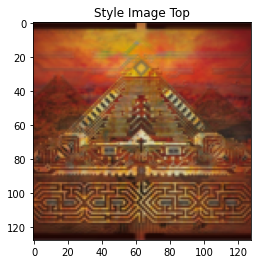

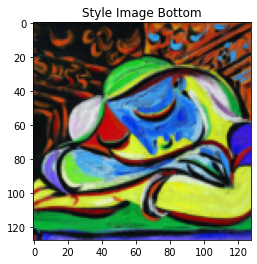

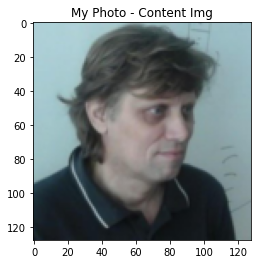

In [22]:
unloader = transforms.ToPILImage() # тензор в кратинку  

plt.ion() 

def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)      # функция для отрисовки изображения
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# отрисовка загруженных отнормированных изображений

plt.figure()
imshow(style1_img, title='Style Image Top')

plt.figure()
imshow(style2_img, title='Style Image Bottom')

plt.figure()
imshow(content_img, title='My Photo - Content Img')

Теперь нужно создать функции, которые будут вычислять расстояния ( $D_C$ и $D_S$). <br />
Они будут выполенены в виде слоев, чтобы брать по ним автоградиент.

$D_S$ - средняя квадратичная ощибка input'а и target'а

In [23]:
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, in_data):
            self.loss = F.mse_loss(in_data, self.target)
            return in_data

Матрица грама позволяет учесть не только сами значения feature map'а, но и кореляцию фич друг с другом. <br /> Это нужно для того, чтобы сделать акцент на встречаемость фич с друг другом, а не на их геометрическом положении. <br />
Полное понимание этого момента можно получить с помощью [этого](https://arxiv.org/pdf/1508.06576.pdf)  и [этого](https://m.habr.com/company/mailru/blog/306916/).

Таким образом:

$D_S$  = $\sum$($G_{ij}$($img_1$) - $G_{ij}$($img_2$)$)^{2}$

Сначала задаем спрособ подсчета матрицы грама: Это просто тензорное тензорное произведение вектора выхода уровня самого на себя.<br /> Однка наш выход - не вектор. В этом случае операция тоже возможна,<br /> но мы получим тензор третьего ранга. Поэтому перед перемножением выход нужно привести к форме вектора.<br />

Подготовим матрицу Грама

In [24]:
def gram_matrix(in_data):
        batch_size, f_map_num, h, w = in_data.size()  # batch size(=1)
        # b=number of feature maps
        # (h,w)=dimensions of a feature map (N=h*w)
        # batch_size = 1

        features = in_data.view(batch_size * f_map_num, h*w)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * h * w * f_map_num)


Mатрица слияния типов: строится попиксельно ("длинный пиксель" -по лекции)

1 - слияние стиля1<br>
0 - стияние стиля2

In [25]:
in_data = torch.empty(1, 1, 128, 128)
mask1 = torch.zeros_like(in_data)
_, _, h, _ = in_data.size()
mask1[:, :, :h // 2, :] +=1
print(mask1)

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])


In [26]:
class StyleLoss(nn.Module):
        def __init__(self, target_feature, mode):
            super(StyleLoss, self).__init__()
            self.target = gram_matrix(target_feature).detach()
            self.mode = mode
            self.loss = F.mse_loss(self.target, self.target)# to initialize with something

        def forward(self, in_data):
            if self.mode == 1:
                mask1 = torch.zeros_like(in_data)
                _, _, h, _ = in_data.size()
                mask1[:, :,  :h // 2, :] +=1   
            else:
                mask1 = torch.zeros_like(in_data)
                _, _, h, _ = in_data.size()
                mask1[:, :,  h // 2:, :] += 1
            inpu = in_data.clone()
            inp = inpu * mask1
            G = gram_matrix(inp)
            self.loss = F.mse_loss(G, self.target)
            return in_data

При тренировке VGG каждое изображение на котором она обучалась было нормировано по всем каналам (RGB). Если мы хотим изпользовать ее для нашей модели, то мы должны реализовать нормировку и для наших изображений тоже.

Тут использовались нормирующие к-ты специально подобранные для VGG


In [27]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [28]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = torch.tensor(mean).view(-1, 1, 1)
            self.std = torch.tensor(std).view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

Теперь соберем это все в одну функцию, которая отдаст на выходе модель и две функции потерь 

Определим после каких уровней мы будем счиатать ошибки стиля, а после каких ошибки контента

Определим предобученную модель

In [29]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [30]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style1_img, style2_img, content_img):
        content_layers= ['conv_4']   # слой вывода контента
        style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'] # слои свертки для стилей
        cnn = copy.deepcopy(cnn)
        global mode
        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style_losses1 = []
        style_losses2 = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization)

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                mode = 1
                
                target_feature1 = model(style1_img).detach()
                style_loss1 = StyleLoss(target_feature1, mode)
                model.add_module("style_loss1_{}".format(i), style_loss1)
                style_losses1.append(style_loss1)
                mode = 2
                
                target_feature2 = model(style2_img).detach()
                style_loss2 = StyleLoss(target_feature2, mode)
                model.add_module("style_loss2_{}".format(i), style_loss2)
                style_losses2.append(style_loss2)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего styel loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style_losses1, style_losses2, content_losses

In [31]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

Дальше стандартный цикл обучения?<br /> Это функция, которая вызывается во время каждого прохода, чтобы пересчитать loss.

In [32]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                         input_img, style1_img, style2_img, content_img, num_steps=500,
                        style_weight1=100000, style_weight2=100000, content_weight=1):
        """Run the style transfer."""
        print('Building the style transfer model..')

        model, style_losses1, style_losses2, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style1_img, style2_img, content_img)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style_score1 = 0
                style_score2 = 0
                content_score = 0

                for sl in style_losses1:
                    style_score1 += sl.loss
                
                for sl in style_losses2:
                    style_score2 += sl.loss

                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style_score1 *= style_weight1
                style_score2 *= style_weight2
                content_score *= content_weight

                loss = style_score1 + style_score2 + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 50 == 0:
                    print("run {}:".format(run))
                    print('Style Loss1 : {:4f} Style Loss2 : {:4f} Content Loss: {:4f}'.format(
                        style_score1.item(), style_score2.item(), content_score.item()))
                    # print()
                    plt.figure()
                    img = input_img.clone()
                    imshow(img, title='Output Image step=%d' % run[0]  )
                    plt.ioff()
                    plt.show()


                return style_score1 + style_score2 + content_score

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss1 : 18.223259 Style Loss2 : 53.863228 Content Loss: 275.950928


<Figure size 432x288 with 0 Axes>

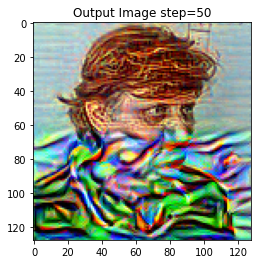

run [100]:
Style Loss1 : 18.344458 Style Loss2 : 52.558567 Content Loss: 254.865463


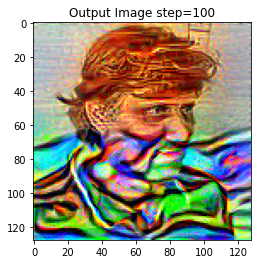

run [150]:
Style Loss1 : 14.582334 Style Loss2 : 47.224277 Content Loss: 246.149185


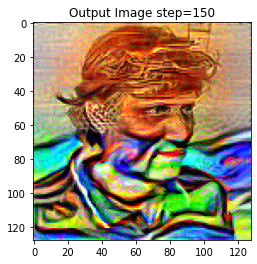

run [200]:
Style Loss1 : 16.278379 Style Loss2 : 62.908722 Content Loss: 266.010986


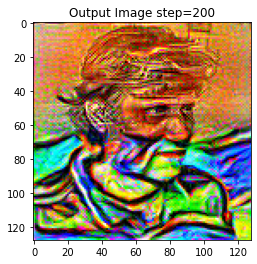

run [250]:
Style Loss1 : 16.140501 Style Loss2 : 102.410965 Content Loss: 259.990845


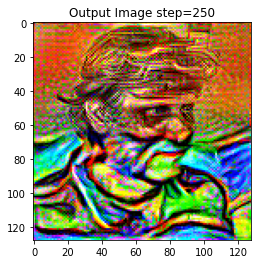

In [52]:
input_img = content_img.clone()

plt.figure()
#imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            input_img, style1_img, style2_img, content_img, style_weight1=1e4, style_weight2=1e4, content_weight=3, num_steps=250)

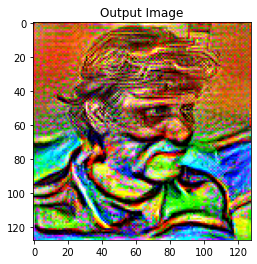

In [53]:
plt.figure()
imshow(output, title='Output Image')
#plt.imsave(output, 'output.png')
# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

**Вывод**
-------
1. Подгонка параметров  весов для каждого стиля происходит индивидуально<br>
Было опопробованы стили разных художников на разных картинах: Ренуар, Пикоссо, Писаро, Ван-Гог
2. Не всегода  кол-во итераций приводит к сходимости моделей. Это видно по промежуточным выводам.
3. Пробовали VGG заменить на RosNet - но положительных результатов не получили
